In [19]:
#CNN Model oversampling  ..........
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler



# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['Manual_annotation'].map(y_dict)
y = pd.get_dummies(df['Manual_annotation']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=5, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

> Average Accuracy across 10-folds: 74.76% (+/- 0.61%)


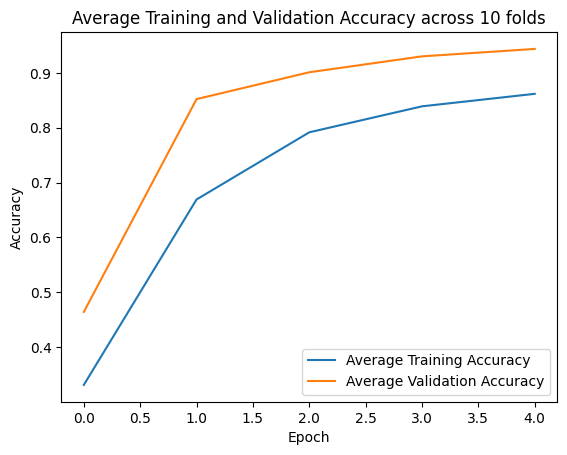

In [21]:
# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


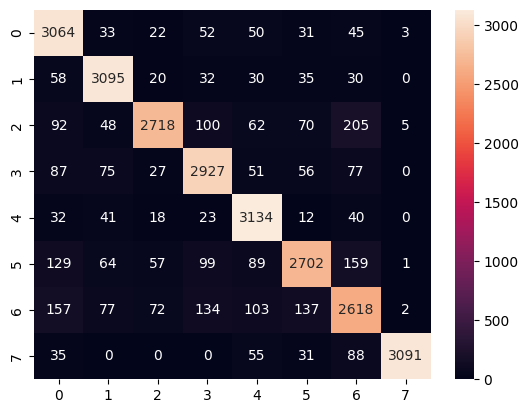

In [22]:
# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


In [23]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                precision    recall  f1-score   support

         anger       0.84      0.93      0.88      3300
     confusion       0.90      0.94      0.92      3300
disappointment       0.93      0.82      0.87      3300
      distrust       0.87      0.89      0.88      3300
       disgust       0.88      0.95      0.91      3300
   frustration       0.88      0.82      0.85      3300
          fear       0.80      0.79      0.80      3300
       sadness       1.00      0.94      0.97      3300

      accuracy                           0.88     26400
     macro avg       0.89      0.88      0.88     26400
  weighted avg       0.89      0.88      0.88     26400



Under Sampling code

In [24]:







#CNN Model manual Dataset undersampling  ..........
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler  # Import RandomUnderSampler for undersampling

# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['Manual_annotation'].map(y_dict)
y = pd.get_dummies(df['Manual_annotation']).values

# 2. Undersample to balance classes
undersampler = RandomUnderSampler(random_state=42)  # Use RandomUnderSampler for undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)



# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')


> Average Accuracy across 10-folds: 12.57% (+/- 2.79%)


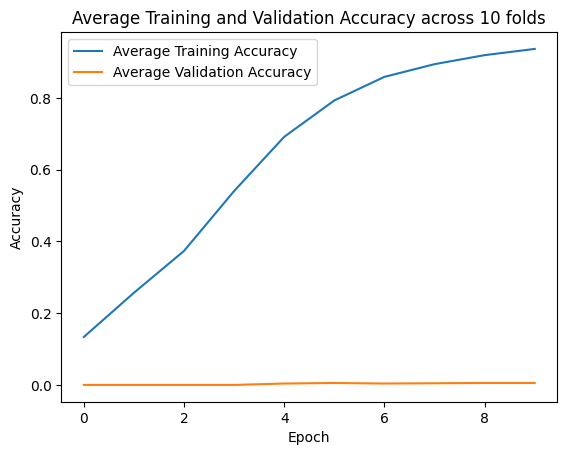

In [26]:
# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


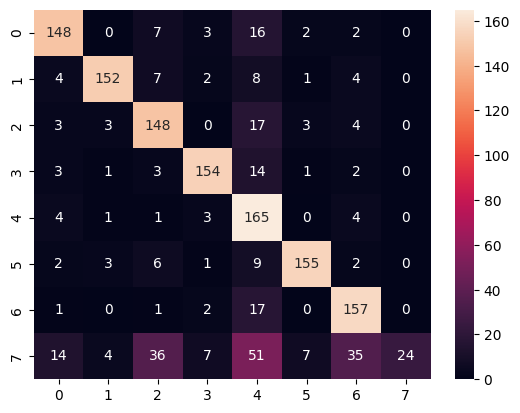

In [27]:
# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


In [28]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                precision    recall  f1-score   support

         anger       0.83      0.83      0.83       178
     confusion       0.93      0.85      0.89       178
disappointment       0.71      0.83      0.76       178
      distrust       0.90      0.87      0.88       178
       disgust       0.56      0.93      0.69       178
   frustration       0.92      0.87      0.89       178
          fear       0.75      0.88      0.81       178
       sadness       1.00      0.13      0.24       178

      accuracy                           0.77      1424
     macro avg       0.82      0.77      0.75      1424
  weighted avg       0.82      0.77      0.75      1424



/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


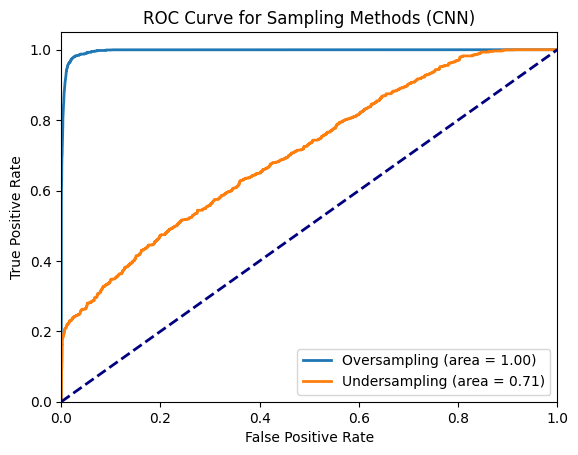

In [29]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# Load and preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])

X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

# Define class labels, oversampling, and undersampling
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['Manual_annotation'].map(y_dict)
y = pd.get_dummies(df['Manual_annotation']).values

oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

# Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model for oversampling
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
model_oversampling = create_model()
model_oversampling.fit(X_oversampled, y_oversampled, epochs=10, batch_size=32, verbose=0)

# Train and evaluate the model for undersampling
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)
model_undersampling = create_model()
model_undersampling.fit(X_undersampled, y_undersampled, epochs=10, batch_size=32, verbose=0)

# Function to plot ROC curve and calculate AUC
def plot_roc_auc(models, X, y, titles):
    plt.figure()
    for model, title in zip(models, titles):
        y_pred = model.predict(X)
        fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{title} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Sampling Methods (CNN)')
    plt.legend(loc='lower right')
    plt.show()

# Plot both ROC curves on the same diagram
plot_roc_auc([model_oversampling, model_undersampling], X_oversampled, y_oversampled[:, 1], titles=['Oversampling', 'Undersampling'])


In [30]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


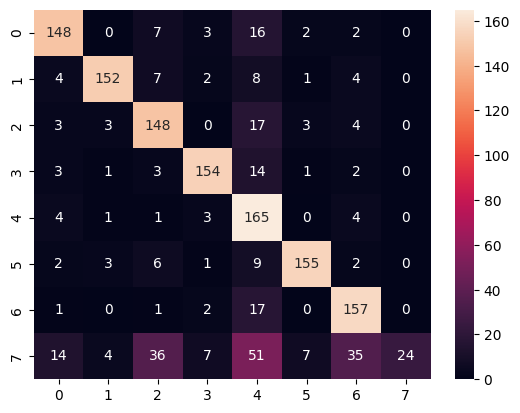

In [31]:
# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# ROC Curve
n_classes = len(y_dict)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_resampled[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



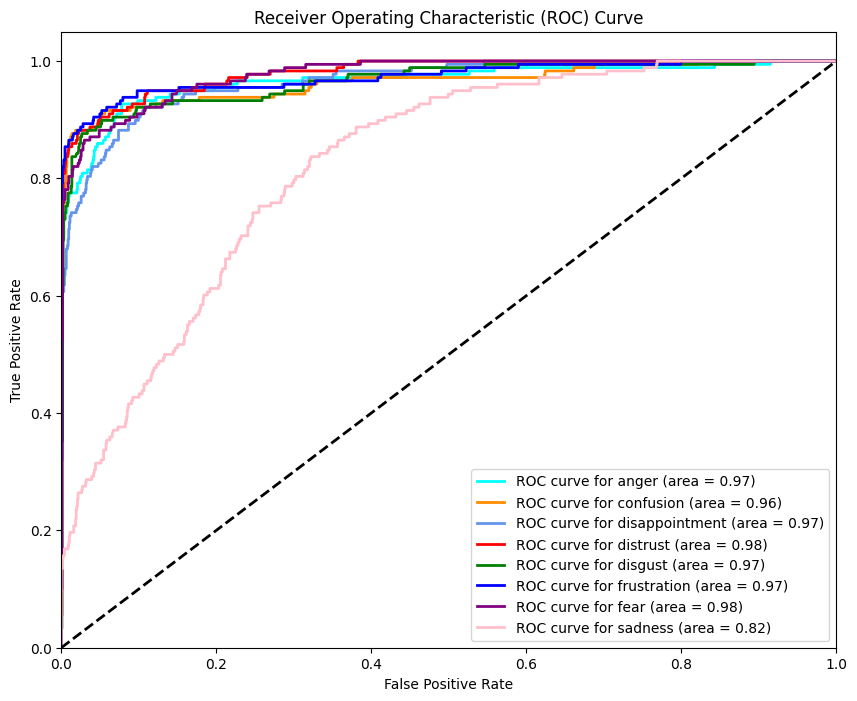

In [32]:
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'pink']
for i in range(n_classes):
   plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for {list(y_dict.keys())[i]} (area = {roc_auc[i]:.2f})')

    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()



In [33]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                precision    recall  f1-score   support

         anger       0.83      0.83      0.83       178
     confusion       0.93      0.85      0.89       178
disappointment       0.71      0.83      0.76       178
      distrust       0.90      0.87      0.88       178
       disgust       0.56      0.93      0.69       178
   frustration       0.92      0.87      0.89       178
          fear       0.75      0.88      0.81       178
       sadness       1.00      0.13      0.24       178

      accuracy                           0.77      1424
     macro avg       0.82      0.77      0.75      1424
  weighted avg       0.82      0.77      0.75      1424



In [34]:
# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')



> Average Accuracy across 10-folds: 12.57% (+/- 2.79%)


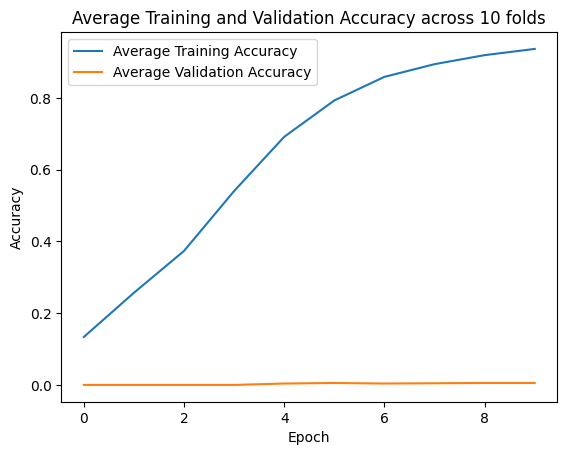

In [35]:
# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
